# Make the monthly ICU TRMM maps from the daily TRMM data

In [37]:
%matplotlib inline

In [38]:
import sys, os, glob
sys.path.append(os.path.join(os.environ['HOME'], 'pythonlibs/'))
import numpy as np
from numpy import ma
from string import rjust
from netCDF4 import num2date, Dataset, MFDataset
from sets import Set 
import colormaps_functions as cf
from matplotlib import cm
from glob import glob
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

### Plotting function

**note**: change: 

`resolution='c'`
    
to 
    
`resolution='h'`
    
to get basemap in high resolution

In [39]:
def plot_TRMM_ICU(lat,lon,data,vmin,vmax,step,cmap,title,fname):

   ll_lon = domain[0]
   ur_lon = domain[1]
   ll_lat = domain[2]
   ur_lat = domain[3]
   

   fig = plt.figure(figsize=(9.5,4.9))
   ax = fig.add_axes([0.03,0.05,0.92,0.9])

   curr_map = Basemap(projection='cyl', llcrnrlon=ll_lon, llcrnrlat=ll_lat, urcrnrlon=ur_lon, urcrnrlat=ur_lat,\
                      resolution='c', ax=ax, area_thresh=1000.)

   x, y = curr_map(*np.meshgrid(lon, lat))

   im = curr_map.pcolormesh(x, y, data, vmin=vmin, vmax=vmax, cmap = cmap)

   plt.title(title, fontsize=16)

   #curr_map.drawcoastlines(linewidth=1,color='0.8')
   curr_map.drawcoastlines(linewidth=0.5,color='k')
   #cont_poly = curr_map.fillcontinents(color='k')

   #draw parallels and meridians.
   delat = 10.
   circles = np.arange(-50.,10. + delat, delat)
   curr_map.drawparallels(circles, labels=[1,0,0,0], fontsize=14, linewidth=0.8, color='k')
   delon = 10.
   meridians = np.arange(ll_lon,ur_lon, delon)
   curr_map.drawmeridians(meridians, labels=[0,0,0,1], fontsize=14, linewidth=0.8, color='k')

   #cb = curr_map.colorbar(im,location='right', pad='2%', size='2%')
   cb = curr_map.colorbar(im,location='right', ticks=np.arange(vmin,vmax+step,step), boundaries=np.arange(vmin,vmax+step/2,step/2), drawedges=True, pad='1.8%')
   cb.ax.set_yticklabels([str(ll).rjust(3," ") for ll in np.arange(vmin,vmax+step,step,dtype=np.int32)])
   cb.set_label("$mm.day^{-1}$", fontsize=16)
   for t in cb.ax.get_yticklabels():
       t.set_fontsize(12)
       t.set_color('k')

   plt.savefig(os.path.join(fpath,fname), dpi=200)

### date 

In [40]:
today = datetime.utcnow()

### if we are before the 25th of the month, we get data for last month

In [41]:
if today.day < 25: 
    date = today - timedelta(days=25) 
else: 
    date = today
print("Processing {}".format(date.strftime("%B %Y")))

Processing March 2015


### path where the figures will be saved

In [42]:
fpath = os.path.join(os.environ['HOME'], 'operational/ICU/supplement/TRMM/figures/')

### lat and lon definitions

In [43]:
nlat = 400
nlon = 1440

### create lat and lon vectors
lon = np.arange(0.125, 0.125 + nlon * 0.25, 0.25) 
lat = np.arange(-49.875, -49.875 + nlat * 0.25, 0.25)

### set the domain we want [lonW, lonE, latS, latN]
domain = [135., 240., -50., 10.]

ilon = np.where( (lon >= domain[0]) & (lon <= domain[1]))[0]
ilat = np.where( (lat >= domain[2]) & (lat <= domain[3]))[0]

lon = lon[ilon]
lat = lat[ilat]

### calculates the climatology for the month

In [44]:
dclimp = os.path.join(os.environ['HOME'],'data/TRMM/climatology/daily')
mclim = ma.empty((12,len(lat),len(lon)))
for i,m in enumerate(np.arange(1,13)):# loop over the months
    ml = str(m).rjust(2,"0")
    liste_files = glob(os.path.join(dclimp, "3B42_daily."+ml+"*.nc"))
    liste_files.sort()
    matf = ma.empty((len(liste_files),len(lat),len(lon)))
    for ifile, fname in enumerate(liste_files):
        nc = Dataset(fname,'r')
        latnc = nc.variables['latitude']
        lonnc = nc.variables['longitude']
        trmm = np.squeeze(nc.variables['hrf'][:,( (lat >= domain[2]) & (lat <= domain[3]) ),\
                                              ( (lon >= domain[0]) & (lon <= domain[1]) )])
        trmm = ma.masked_values(trmm,-9999.)
        matf[ifile,:,:] = trmm
        nc.close()

    mclim[i,:,:] = matf.mean(0) #mclim is the monthly climatology

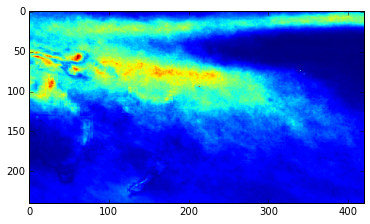

In [45]:
plt.imshow(mclim[0,::-1,:])

In [46]:
ddailyp = os.path.join(os.environ['HOME'],'data/TRMM/daily')

mmonths = ma.empty((len(lat),len(lon)))
amonths = ma.empty((len(lat),len(lon)))

# ml = str(date.month).rjust(2,"0")
ml = date.strftime("%m")

liste_files = glob(os.path.join(ddailyp,"3B42RT_daily." + str(date.year) + "." + ml + ".*.nc"))
liste_files.sort()
matf = ma.empty((len(liste_files),len(lat),len(lon)))
for ifile, fname in enumerate(liste_files):
    nc = Dataset(fname,'r')
    trmm = np.squeeze(nc.variables['trmm'][:,( (lat >= domain[2]) & (lat <= domain[3]) ),( (lon >= domain[0]) & (lon <= domain[1]) )])
    trmm = ma.masked_values(trmm,-99999.)
    matf[ifile,:,:] = trmm
    nc.close()
# calculate mean
mmonths[:,:] = matf.mean(0)
# calculate anomalies
amonths[:,:] = ma.subtract(matf.mean(0), mclim[(date.month - 1),:,:])

### plots the average

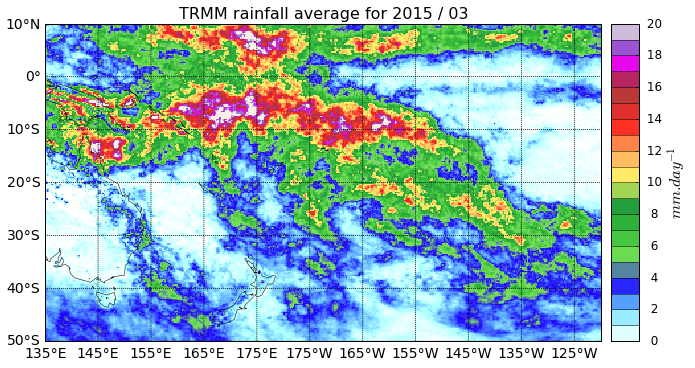

In [49]:
cmap = cf.readnclcolormaps('prcp_1')
plot_TRMM_ICU(lat,lon,mmonths[:,:],0,20,2,cmap,'TRMM rainfall average for {}'.format(date.strftime("%Y / %m")),\
              "ave_TRMM_{}.png".format(date.strftime("%Y_%m")))

### plots the anomalies

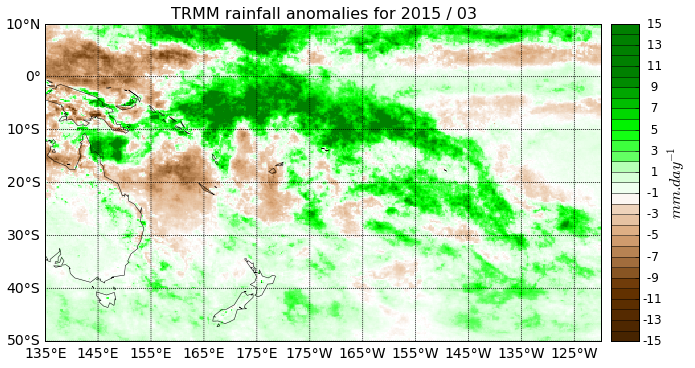

In [50]:
cmap = cf.gmtColormap('departure')
plot_TRMM_ICU(lat,lon,amonths[:,:],-15.,15.,2,cmap,'TRMM rainfall anomalies for {}'.format(date.strftime("%Y / %m")),\
              "anoms_TRMM_{}.png".format(date.strftime("%Y_%m")))